# SyntheticBenchmark50
Do a synthetic benchmark with a 50 node network and model14
## -1
1. Imports
2. Make a directory for the outputs of this notebook if it doesn't exist
3. Set up logging
4. Global variables
## 0 Ground Truth Generation
1. Choose 3 bait and 50 node
2. Generate a network of direct protein-protein interactions
3. Ensure everything is connected to the bait
## 1 Data Generation
1. Generate profile similarities given the network
## 2 Fitting
1. Generate M chains of N samples each, saving to files
2. Ensure the score is saved
3. Optionally check sampling diagnostics
## 3 Analysis
1. Calculate accuracy for every position - (True accuracy metric)
2. Save the top accuracy
3. Save the top scoring model
2. Accuracy score precision
## 4 Increased Sampling
1. Calculate a dictionary of increasing combinations of the M chains
## 5 Plots
1. Plot accuracy score correlation for a representative trajectory
2. Plot top accuracy top score calculation across all trajectories
3. Show top accuracy as a function of increased sampling
4. Show top score as a function of increased sampling
5. Finish

## Scores Used in Numpyro Models
### Terms
- target density   : $\pi (x) $
- Hamiltonian      : $H(x, w) = -\log \pi (x) + V(w)$
- potential energy : $U(x) = -\log \pi(x) $
- kinematic energy : $V(w)$
- log density      : $\log \pi(x)$
- state            : (x, w)
- p(w)             : 

### Implementation
- potential_energy expects unconstrained inputs (done under the hood)



In [195]:
## -1.1 Imports
import datetime
import importlib
import jax
import jax.numpy as jnp
import logging
import networkit as nk
import numpy as np
import numpyro
import math
from pathlib import Path
from functools import partial
import pandas as pd
import sklearn
from types import SimpleNamespace
import matplotlib.pyplot as plt
# Custom modules
import synthetic_benchmark
import _model_variations
import analyze_mcmc_output
import seaborn as sns

# Reload custom modules for devlopment
importlib.reload(synthetic_benchmark)
importlib.reload(_model_variations)
importlib.reload(analyze_mcmc_output)


<module 'analyze_mcmc_output' from '/Users/aji/Projects/benchmark_results/notebooks/analyze_mcmc_output.py'>

In [2]:
## -1.2 Make a directory if it doesn't exist
nb_write_path = Path("SyntheticBenchmark50")
if not nb_write_path.is_dir():
    nb_write_path.mkdir()

In [3]:
## -1.3
# Start a new log file to write to
time = datetime.datetime.now()
log_filename = nb_write_path / f"{time.year}_{time.month}_{time.day}_{time.hour}_{time.minute}_SyntheticBenchmark50.log"
# Set up the logger
logging.basicConfig(filename=str(log_filename), encoding="utf-8", level=logging.DEBUG)
logging.info(f"SyntheticBenchmark50 Notebook Begin at {str(time)}")

In [4]:
## -1.4
nb = SimpleNamespace()
nb.rseed = 13
nb.rkey = jax.random.PRNGKey(nb.rseed)
nb.n_keys = 3
nb.keys = jax.random.split(nb.rkey, nb.n_keys)
nb.dev_key = jax.random.PRNGKey(22)
nb.n_prey = 50
nb.tril_idx = np.tril_indices(nb.n_prey)
nb.num_samples = 1000
nb.m_chains = 1000
nb.num_warmup = 500

In [5]:
## 0.1 Ground Truth Generation
def _0_1_ground_truth_generation():
    A, bait_idx, prey_idx = synthetic_benchmark.get_bait_prey_network(nb.keys[0], n_prey=50,
                                                                     n_bait=3, d_crit=20)
    return A, bait_idx, prey_idx

A, bait_idx, prey_idx = _0_1_ground_truth_generation()

In [6]:
bait_idx

Array([ 2, 20, 44], dtype=int32)

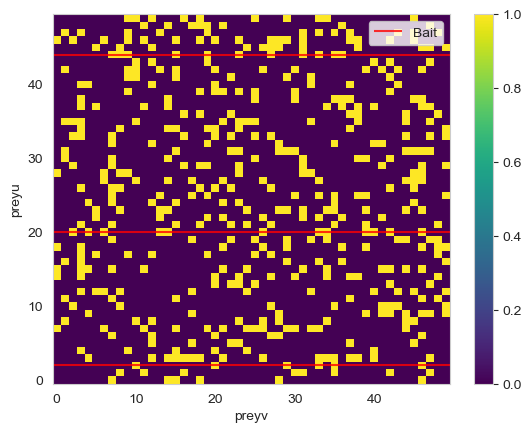

In [7]:
A.plot()
plt.hlines(np.array(bait_idx), -1, 50, label="Bait", alpha=0.8, color='r')
plt.legend()

In [8]:
D = _model_variations.shortest_paths_up_to_23(A.values)

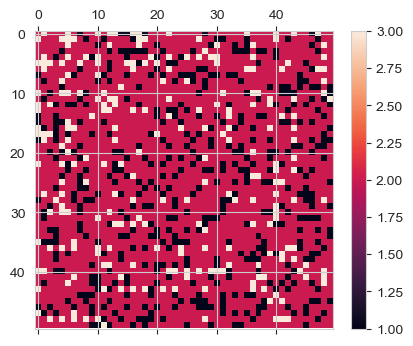

In [9]:
plt.matshow(D)
plt.colorbar(shrink=0.8)

In [10]:
def adjacency2graph(A, weighted=False):
    n, m = A.shape
    G = nk.Graph(n, weighted=weighted)
    for u in range(n):
        for v in range(u+1, m):
            w = A[u, v]
            if weighted:
                G.addEdge(u, v, w)
            else:
                if w > 0:
                    G.addEdge(u, v, w)
    return G
                
            

In [11]:
G = adjacency2graph(A)

Text(0.5, 1.0, 'connected component sizes')

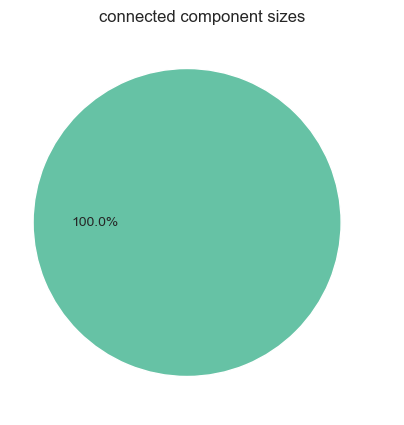

In [12]:
nk.plot.connectedComponentsSizes(G)
plt.title("connected component sizes") # A single connected component

In [13]:
# 1.1 Generate similarities
data = synthetic_benchmark.data_from_network_model14_rng(nb.keys[1], A.values)

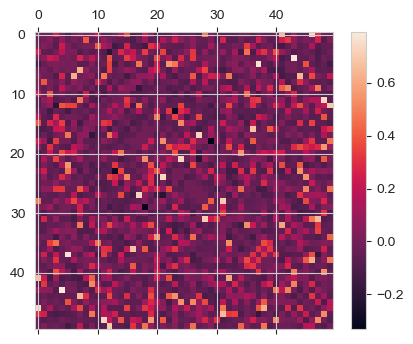

In [14]:

plt.matshow(data)
plt.colorbar(shrink=0.8)

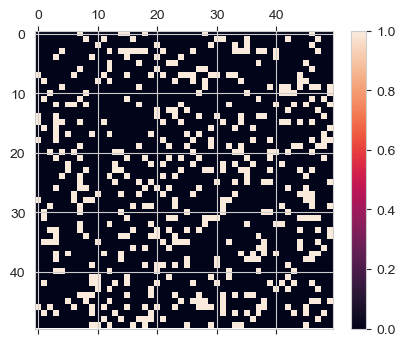

In [15]:
plt.matshow(A.values)
plt.colorbar(shrink=0.8)

In [24]:
reference_flat = _model_variations.matrix2flat(A.values)

In [16]:
data_flat =  _model_variations.matrix2flat(data)
assert len(data_flat) == math.comb(nb.n_prey, 2)

In [122]:
model_data = _model_variations.model14_data_getter()
model_data['flattened_apms_similarity_scores'] = data_flat
model = _model_variations.model14

In [111]:
model_data.keys()

dict_keys(['flattened_apms_similarity_scores', 'flattened_apms_shuffled_similarity_scores'])

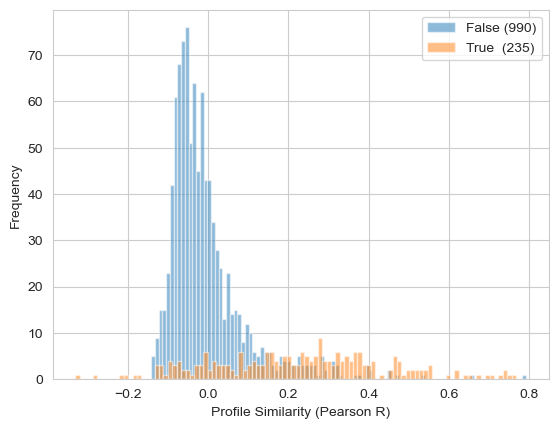

In [174]:
n_true = int(np.sum(reference_flat))
n_false = len(reference_flat) - n_true
plt.hist(np.array(data_flat[reference_flat == 0]), label=f"False ({n_false})", bins=100, alpha=0.5)
plt.hist(np.array(data_flat[reference_flat == 1]), label=f"True  ({n_true})", bins=100, alpha=0.5)
plt.xlabel("Profile Similarity (Pearson R)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [134]:
## 2.1 Fitting
def _2_1_fit():
    for i in range(nb.m_chains):
        savename = Path("SyntheticBenchmark50/") / f"chain_{i}.pkl"
        bool_savename = f"SyntheticBenchmark50/0_model14_{i}.pkl"
        if not Path(bool_savename).is_file():
            logging.info(f"BEGIN sampling {savename}")
            _model_variations._main(
            model_id="0",
            model_name="model14",
            rseed=i,
            model_data=data_flat,
            num_warmup=nb.num_warmup,
            num_samples=nb.num_samples,
            include_potential_energy=True,
            progress_bar=True,
            save_dir="SyntheticBenchmark50",
            include_mean_accept_prob=False,
            include_extra_fields=True)
            logging.info(f"END sampling {savename}")
        else:
            logging.info(f"SKIP sampling {savename} exists.")

_2_1_fit()

Model ID: 0
Model Name: model14
[CpuDevice(id=0)]


model14 in main


sample:  43%|██████████████████████████████████████████                                                         | 638/1500 [00:49<01:06, 12.89it/s, 31 steps of size 2.07e-01. acc. prob=0.85]


KeyboardInterrupt: 

In [75]:
## 3.1 Sampling Analysis
def _3_1():
    for i in range(nb.m_chains):
        # Load in the trajectory
        path = Path("SyntheticBenchmark50/") / f"0_model14_{i}.pkl"
        #d = _model_variations.load(path)
        
        analysis_dict = analyze_mcmc_output.model14_traj2analysis(str(path), np.array(reference_flat))
        # do the sampling analysis
          # calc top score
          # calc accuracy array
          # get the top accuracy
          
          # 0_model14_0 : {top_score, accuracy_array, top_accuracy, potential_energy}
        break
    return analysis_dict
analysis_dict = _3_1()
        

In [76]:
analysis_dict.keys()

dict_keys(['score_array', 'accuracy_array'])

In [ ]:
numpyro.infer.util.log_densitysityty

In [118]:
numpyro.infer.util.log_density
numpyro.infer.util.potential_energy
numpyro.infer.util.log_likelihood

<function numpyro.infer.util.log_likelihood(model, posterior_samples, *args, parallel=False, batch_ndims=1, **kwargs)>

In [119]:
help(numpyro.infer.util.potential_energy)

Help on function potential_energy in module numpyro.infer.util:

potential_energy(model, model_args, model_kwargs, params, enum=False)
    (EXPERIMENTAL INTERFACE) Computes potential energy of a model given unconstrained params.
    Under the hood, we will transform these unconstrained parameters to the values
    belong to the supports of the corresponding priors in `model`.
    
    :param model: a callable containing NumPyro primitives.
    :param tuple model_args: args provided to the model.
    :param dict model_kwargs: kwargs provided to the model.
    :param dict params: unconstrained parameters of `model`.
    :param bool enum: whether to enumerate over discrete latent sites.
    :return: potential energy given unconstrained parameters.



In [124]:
numpyro.infer.util.potential_energy(model, model_data)

TypeError: potential_energy() got an unexpected keyword argument 'model_data'

In [125]:
?numpyro.infer.util.potential_energy

In [ ]:
# Expect to see low scores correlated with high accuracy
# This would make a negative slope

path = Path("SyntheticBenchmark50") / f"0_model14_0.pkl"
_0_model14_0 = _model_variations.load(str(path))
analysis_dict = analyze_mcmc_output.model14_traj2analysis(str(path), 
        model_data=model_data, model=model, reference=np.array(reference_flat))

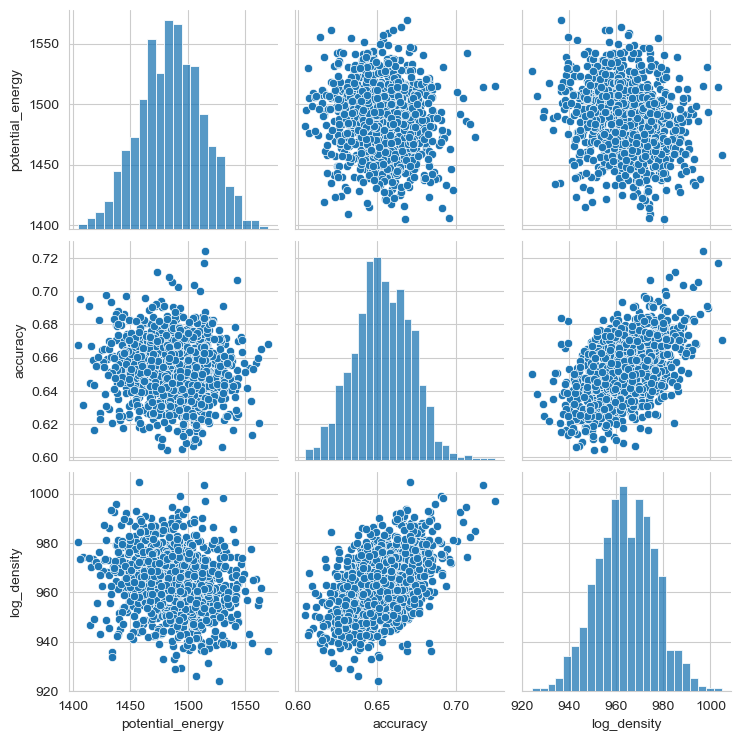

In [182]:
sns.set_style
sns.pairplot(pd.DataFrame(analysis_dict))
plt.show()

<function _model_variations.model14(model_data)>

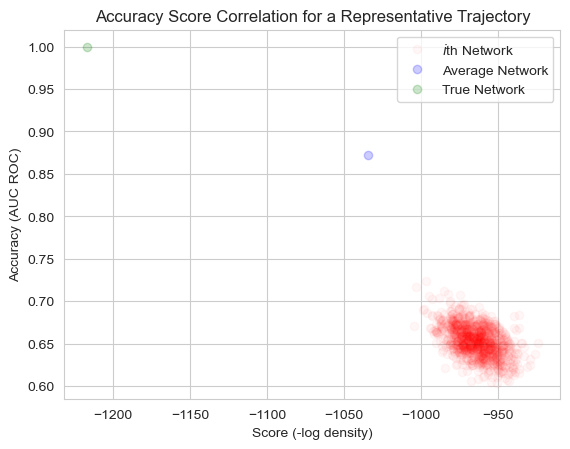

In [207]:
scores = -np.array(analysis_dict['log_density'])
accuracy = np.array(analysis_dict['accuracy'])
plt.plot(scores, accuracy, 'ro', alpha=0.03,
        label="$i$th Network")
plt.xlabel("Score (-log density)")
plt.ylabel("Accuracy (AUC ROC)")
plt.title("Accuracy Score Correlation for a Representative Trajectory")

average_network = np.mean(_0_model14_0['samples']['pT'], axis=0)
average_network_accuracy = sklearn.metrics.roc_auc_score(reference_flat, average_network)

model14_log_density_func = partial(numpyro.infer.util.log_density,
            model=model, model_args=(model_data,), model_kwargs={},)

average_network_log_density, _ = model14_log_density_func(params={"pT": average_network})

plt.plot(-average_network_log_density, average_network_accuracy, 'bo',
        alpha=0.2, label="Average Network")

true_network_accuracy = sklearn.metrics.roc_auc_score(reference_flat,
                                                     reference_flat)
true_network_log_density, _ = model14_log_density_func(params={"pT":
                reference_flat})
plt.plot(-true_network_log_density, true_network_accuracy,
        'go', alpha=0.2, label="True Network")
plt.legend()

# Score of the true network
_model_variations.model14


#sns.pairplot(pd.DataFrame(analysis_dict))


Conclusion:
- The model score is well correlated to accuracy on this synthetic example.
- The average network achieves an accuracy of 0.87

Is this a funciton of sampling?


In [161]:
numpyro.infer.util.potential_energy(model, 
                                    model_args=(model_data,), 
                                    model_kwargs={}, params={'pT': average_network})

Array(963.91223, dtype=float32)

In [165]:
values = numpyro.infer.util.log_density(model, (model_data,), {}, 
                                        {'pT': _0_model14_0['samples']['pT'] })

ValueError: Incompatible shapes for broadcasting: shapes=[(1225, 1000), (1225,), (1225,)]

In [166]:
?numpyro.infer.util.log_density

In [61]:
sklearn.metrics.accuracy_score(np.array(data_flat), np.array(reference_flat))

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [66]:
sklearn.metrics.roc_auc_score(reference_flat, data_flat)

0.8256952503761014

In [67]:
?sklearn.metrics.roc_auc_score